# Project 7
## EAE 127
## Manbir Kaberwal


In [1]:
## Imports ##

import pyxfoil
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from scipy.interpolate import interp1d
from mpl_toolkits.mplot3d import Axes3D

# 1.) Simple Lattice Method 

## Approach 

## Equations

## Code

ValueError: s must be a scalar, or float array-like with the same size as x and y

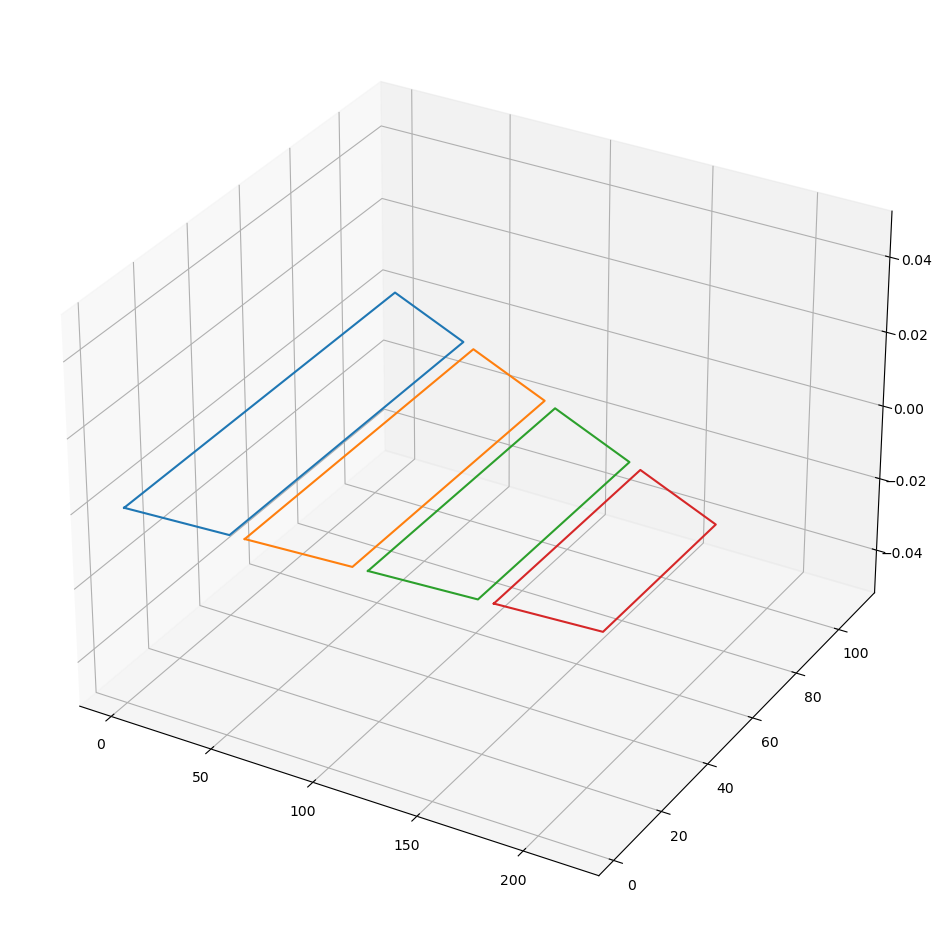

In [28]:
filenames = ['Data/PanelData/Panel_1_Coordinates.dat', 'Data/PanelData/Panel_2_Coordinates.dat', 'Data/PanelData/Panel_3_Coordinates.dat', 'Data/PanelData/Panel_4_Coordinates.dat']

# Create a single 3D subplot
fig = plt.figure(figsize=(30, 12))
ax = fig.add_subplot(111, projection='3d')

# Plot each panel's data
for filename in filenames:
    data = np.loadtxt(filename, skiprows=2)
    x, y = data[:, 0], data[:, 1]
    ax.plot(x, y, zs=0, zdir='z', label=filename.split('/')[-1])

controlpoints = 'Data/PanelData/Control_Points.dat'
xC, yC  = np.loadtxt(controlpoints, dtype=float, unpack=True, skiprows=2)
plt.scatter(xC, yC, label = 'Control Points', marker = 'o')

vortex = 'Data/PanelData/Vortex_Points.dat'
Xv, Yv = x, z = np.loadtxt(vortex, dtype=float, unpack=True, skiprows=2)
plt.scatter(Xv, Yv, label = 'Vortex Points', marker= 'X')

# Load and plot the planform data
planform = 'Data/PanelData/Planform_Coordinates.dat'
wingplanx, wingplany = np.loadtxt(planform, dtype=float, unpack=True, skiprows=2)
ax.plot(wingplanx, wingplany, zs=0, zdir='z', label='Planform')
ax.scatter(Xv, Yv, 0) ##VOrtex Points
ax.scatter(xC, yC, 0) ## Control Points

# Show legend and plot title
ax.legend()
ax.set_title('3D Projection of P51D Wing')

# Display the plot
plt.show()


In [4]:
# Assigning values to variables
Vinf_mph = 350        # mph
Vinf = Vinf_mph * 5280 / 3600
alpha = 7      # degrees
rho = 11.866e-4
S = 235  # Wing Area in square feet
root = 8.48  # Root Chord Length in feet
b = 48  # Wing Span in feet
h = 22000  # Geometric Cruise Altitude in feet
W = 9200  # Loaded Weight in lbs
μ = 3.25e-6  # Dynamic Viscosity (at h) in slugs/(ft * s)


# Load Control Points from File:
CP = np.loadtxt('Data/Problem1date/Control_Points.dat', unpack = True, skiprows = 2)
cp_x, cp_y = CP[0], CP[1]
# Load Vortex Points from Canvas Files
Left = np.loadtxt('Data/Problem1date/Left Vortex_Points.dat', unpack = True, skiprows = 2)
lvp_x, lvp_y = Left[0], Left[1]

Right = np.loadtxt('Data/Problem1date/Right Vortex_Points.dat', unpack = True, skiprows = 2)
rvp_x, rvp_y = Right[0], Right[1]


def SLM_calc(cp_x, cp_y, lvp_x, lvp_y, rvp_x, rvp_y, S, b, Vinf, alpha, rho):
    """
    This is our Simple Lattice Method Solver
    The inputs as above are as follows
    CP_x, CP_y, these are the coordinates of our control points. Each one should be a 4x1 array
    LVP_x, LVP_y, left vortex point
    RVP_x, RVP_y, right vortex point
    S = area of wing
    b = span of wing (from left wing tip to right wing tip)
    The above inputs depend only on geometry of the wing

    Vinf = freestream flow or speed of aircraft
    alpha = desired angle of attack calculation (this needs to be in radians)
    rho = density of air at prescribed altitude
    """

    DW_star = np.zeros((4,4), float)
    DW_port = np.zeros((4,4), float)

    S = S
    b = b
    Vinf = Vinf
    alpha = alpha 
    rho = rho

    CP_X = cp_y 
    CP_Y = cp_x 

    LVP_X = lvp_y 
    LVP_Y = lvp_x 

    RVP_X = rvp_y 
    RVP_Y = rvp_x 

    # Here, all we've done is swap the coordinates. The way we plotted our coordinates in P6 we left X on horizontal and y on horizontal.
    # We need to swap them here because the equations refer to y on the horizontal 
    # We should quickly grab the distance between control points. Students will fill this in/determine this:

    dy = CP_Y[1] - CP_Y[0]

    # In Project 6, we only used one side of the wing. However, this method requires us to consider both sides of the wing. Due to this, we need to create two new variables. 
    # Our wing is symmetric, about x = 0, y = 0. This means we just need to set the horizontal coordinates to negatives. 

    LVP_Ys = -1*LVP_Y
    RVP_Ys = -1*RVP_Y

    # Generally, to describe this method, we are going to use the coordinates from the starboard side of the wing, and calculate their contribution at each panel. Then we will add the contributions
    # from the port side of the wing and solve a system of equations. 

    for i in range(0, 4): # i represents control panels (m) , j means other panels and their vortices (n)
    # Starboard Side of Wing
        for j in range(0, 4):
        
            Cent = 1.0 / ((CP_X[i] - LVP_X[j])*(CP_Y[i] - RVP_Y[j]) - (CP_X[i] - RVP_X[j])*(CP_Y[i] - LVP_Y[j]))

            VL_main =   ((RVP_X[j] - LVP_X[j])*(CP_X[i] - LVP_X[j]) + (RVP_Y[j] - LVP_Y[j])*(CP_Y[i] - LVP_Y[j]))/(np.sqrt(( CP_X[i] - LVP_X[j])**2 + ( CP_Y[i] - LVP_Y[j])**2))

            VR_main = - ((RVP_X[j] - LVP_X[j])*(CP_X[i] - RVP_X[j]) + (RVP_Y[j] - LVP_Y[j])*(CP_Y[i] - RVP_Y[j]))/(np.sqrt(( CP_X[i] - RVP_X[j])**2 + ( CP_Y[i] - RVP_Y[j])**2))

            LV = (1.0 / (LVP_Y[j] - CP_Y[i])) * (1.0 + ((CP_X[i] - LVP_X[j]) / (np.sqrt(( CP_X[i] - LVP_X[j])**2 + ( CP_Y[i] - LVP_Y[j])**2))))
        
            RV = (-1.0 / (RVP_Y[j] - CP_Y[i]))* (1.0 + ((CP_X[i] - RVP_X[j]) / (np.sqrt(( CP_X[i] - RVP_X[j])**2 + ( CP_Y[i] - RVP_Y[j])**2))))

            DW_star[i, j] = (Cent * (VL_main+VR_main)) + LV + RV

    # Port Side of Wing
        for j in range(0,4):
            Cent = 1.0 / ((CP_X[i] - LVP_X[j])*(CP_Y[i] - RVP_Ys[j]) - (CP_X[i] - RVP_X[j])*(CP_Y[i] - LVP_Ys[j]))

            VL_main =   ((RVP_X[j] - LVP_X[j])*(CP_X[i] - LVP_X[j]) + (RVP_Ys[j] - LVP_Ys[j])*(CP_Y[i] - LVP_Ys[j]))/(np.sqrt(( CP_X[i] - LVP_X[j])**2 + ( CP_Y[i] - LVP_Ys[j])**2))

            VR_main = - ((RVP_X[j] - LVP_X[j])*(CP_X[i] - RVP_X[j]) + (RVP_Ys[j] - LVP_Ys[j])*(CP_Y[i] - RVP_Ys[j]))/(np.sqrt(( CP_X[i] - RVP_X[j])**2 + ( CP_Y[i] - RVP_Ys[j])**2))

            LV = (1.0 / (LVP_Ys[j] - CP_Y[i])) * (1.0 + ((CP_X[i] - LVP_X[j]) / (np.sqrt(( CP_X[i] - LVP_X[j])**2 + ( CP_Y[i] - LVP_Ys[j])**2))))
        
            RV = (-1.0 / (RVP_Ys[j] - CP_Y[i]))* (1.0 + ((CP_X[i] - RVP_X[j]) / (np.sqrt(( CP_X[i] - RVP_X[j])**2 + ( CP_Y[i] - RVP_Ys[j])**2))))

            DW_port[i, j] = -1* ((Cent * (VL_main+VR_main)) + LV + RV)

    DW = DW_star + DW_port

    # After running the above block of code and the equations, we arrive at an array that represents a system of equations. Our matrix is 4 x 4, so this is a matrix of 4 equations and 4 unknowns.
    # Our next step is to solve this system of equations. In order to do this, we need to construct the right hand side of the system of equations. The Right hand side will consist of the
    # flight conditions we are using for this wing

    # We only have 4 panels, meaning we need 4 entries
    # Calculate RHS
    wRHS = [4 * (np.pi) * Vinf * alpha]

    # We can now use linear algebra to solve for the circulation at every panel.
    Circ = np.linalg.solve(DW, wRHS)


    # Here we calculate total lift
    L = 2 * np.sum(Circ) * Vinf

    print("ok")


#for filename in filenames:
    #data = np.loadtxt(filename, skiprows=2)
   # x, y = data[:, 0], data[:, 1]

#SLM_calc(cp_x, cp_y, lvp_x, lvp_y, rvp_x, rvp_y, S, b, Vinf, alpha, rho)


In [9]:
# Reading data from .dat files
right_vortex_points = np.loadtxt('Data/Problem1date/Right Vortex_Points.dat', unpack= True, skiprows=2)
left_vortex_points = np.loadtxt('Data/Problem1date/Left Vortex_Points.dat', unpack= True, skiprows=2)
control_points = np.loadtxt('Data/Problem1date/Control_Points.dat', unpack= True, skiprows=2)

# Assigning flight and wing parameters
Vinf_mph = 350        # mph
Vinf = Vinf_mph * 5280 / 3600  # Convert mph to ft/s
alpha = 7 * np.pi / 180  # Convert degrees to radians
rho = 11.866e-4
S = 235  # Wing Area in square feet
b = 48  # Wing Span in feet

# Extracting control and vortex points from the loaded data
cp_x, cp_y = control_points[:, 0], control_points[:, 1]
lvp_x, lvp_y = left_vortex_points[:, 0], left_vortex_points[:, 1]
rvp_x, rvp_y = right_vortex_points[:, 0], right_vortex_points[:, 1]

# SLM_calc function (to be filled with actual logic)
def SLM_calc(cp_x, cp_y, lvp_x, lvp_y, rvp_x, rvp_y, S, b, Vinf, alpha, rho):
    # [The full function logic as provided in the text file should be inserted here]
    # Placeholder return statement
    """
    This is our Simple Lattice Method Solver
    The inputs as above are as follows
    CP_x, CP_y, these are the coordinates of our control points. Each one should be a 4x1 array
    LVP_x, LVP_y, left vortex point
    RVP_x, RVP_y, right vortex point
    S = area of wing
    b = span of wing (from left wing tip to right wing tip)
    The above inputs depend only on geometry of the wing

    Vinf = freestream flow or speed of aircraft
    alpha = desired angle of attack calculation (this needs to be in radians)
    rho = density of air at prescribed altitude
    """

    DW_star = np.zeros((4,4), float)
    DW_port = np.zeros((4,4), float)

    S = S
    b = b
    Vinf = Vinf
    alpha = alpha 
    rho = rho

    CP_X = cp_y 
    CP_Y = cp_x 

    LVP_X = lvp_y 
    LVP_Y = lvp_x 

    RVP_X = rvp_y 
    RVP_Y = rvp_x 

    # Here, all we've done is swap the coordinates. The way we plotted our coordinates in P6 we left X on horizontal and y on horizontal.
    # We need to swap them here because the equations refer to y on the horizontal 
    # We should quickly grab the distance between control points. Students will fill this in/determine this:

    dy = CP_Y[1] - CP_Y[0]

    # In Project 6, we only used one side of the wing. However, this method requires us to consider both sides of the wing. Due to this, we need to create two new variables. 
    # Our wing is symmetric, about x = 0, y = 0. This means we just need to set the horizontal coordinates to negatives. 

    LVP_Ys = -1*LVP_Y
    RVP_Ys = -1*RVP_Y

    # Generally, to describe this method, we are going to use the coordinates from the starboard side of the wing, and calculate their contribution at each panel. Then we will add the contributions
    # from the port side of the wing and solve a system of equations. 

    for i in range(0, 4): # i represents control panels (m) , j means other panels and their vortices (n)
    # Starboard Side of Wing
        for j in range(0, 4):
        
            Cent = 1.0 / ((CP_X[i] - LVP_X[j])*(CP_Y[i] - RVP_Y[j]) - (CP_X[i] - RVP_X[j])*(CP_Y[i] - LVP_Y[j]))

            VL_main =   ((RVP_X[j] - LVP_X[j])*(CP_X[i] - LVP_X[j]) + (RVP_Y[j] - LVP_Y[j])*(CP_Y[i] - LVP_Y[j]))/(np.sqrt(( CP_X[i] - LVP_X[j])**2 + ( CP_Y[i] - LVP_Y[j])**2))

            VR_main = - ((RVP_X[j] - LVP_X[j])*(CP_X[i] - RVP_X[j]) + (RVP_Y[j] - LVP_Y[j])*(CP_Y[i] - RVP_Y[j]))/(np.sqrt(( CP_X[i] - RVP_X[j])**2 + ( CP_Y[i] - RVP_Y[j])**2))

            LV = (1.0 / (LVP_Y[j] - CP_Y[i])) * (1.0 + ((CP_X[i] - LVP_X[j]) / (np.sqrt(( CP_X[i] - LVP_X[j])**2 + ( CP_Y[i] - LVP_Y[j])**2))))
        
            RV = (-1.0 / (RVP_Y[j] - CP_Y[i]))* (1.0 + ((CP_X[i] - RVP_X[j]) / (np.sqrt(( CP_X[i] - RVP_X[j])**2 + ( CP_Y[i] - RVP_Y[j])**2))))

            DW_star[i, j] = (Cent * (VL_main+VR_main)) + LV + RV

    # Port Side of Wing
        for j in range(0,4):
            Cent = 1.0 / ((CP_X[i] - LVP_X[j])*(CP_Y[i] - RVP_Ys[j]) - (CP_X[i] - RVP_X[j])*(CP_Y[i] - LVP_Ys[j]))

            VL_main =   ((RVP_X[j] - LVP_X[j])*(CP_X[i] - LVP_X[j]) + (RVP_Ys[j] - LVP_Ys[j])*(CP_Y[i] - LVP_Ys[j]))/(np.sqrt(( CP_X[i] - LVP_X[j])**2 + ( CP_Y[i] - LVP_Ys[j])**2))

            VR_main = - ((RVP_X[j] - LVP_X[j])*(CP_X[i] - RVP_X[j]) + (RVP_Ys[j] - LVP_Ys[j])*(CP_Y[i] - RVP_Ys[j]))/(np.sqrt(( CP_X[i] - RVP_X[j])**2 + ( CP_Y[i] - RVP_Ys[j])**2))

            LV = (1.0 / (LVP_Ys[j] - CP_Y[i])) * (1.0 + ((CP_X[i] - LVP_X[j]) / (np.sqrt(( CP_X[i] - LVP_X[j])**2 + ( CP_Y[i] - LVP_Ys[j])**2))))
        
            RV = (-1.0 / (RVP_Ys[j] - CP_Y[i]))* (1.0 + ((CP_X[i] - RVP_X[j]) / (np.sqrt(( CP_X[i] - RVP_X[j])**2 + ( CP_Y[i] - RVP_Ys[j])**2))))

            DW_port[i, j] = -1* ((Cent * (VL_main+VR_main)) + LV + RV)

    DW = DW_star + DW_port

    # After running the above block of code and the equations, we arrive at an array that represents a system of equations. Our matrix is 4 x 4, so this is a matrix of 4 equations and 4 unknowns.
    # Our next step is to solve this system of equations. In order to do this, we need to construct the right hand side of the system of equations. The Right hand side will consist of the
    # flight conditions we are using for this wing

    # We only have 4 panels, meaning we need 4 entries
    # Calculate RHS
    wRHS = [4 * (np.pi) * Vinf * alpha]

    # We can now use linear algebra to solve for the circulation at every panel.
    Circ = np.linalg.solve(DW, wRHS)


    # Here we calculate total lift
    L = 2 * np.sum(Circ) * Vinf

    return "SLM_calc function executed"

# Executing the SLM_calc function with the provided data
SLM_calc_result = SLM_calc(cp_x, cp_y, lvp_x, lvp_y, rvp_x, rvp_y, S, b, Vinf, alpha, rho)
print(SLM_calc_result)

IndexError: index 2 is out of bounds for axis 0 with size 2

# Problem 2 Wing Planform Distribution Effects

## Approach

## Equations

## Code


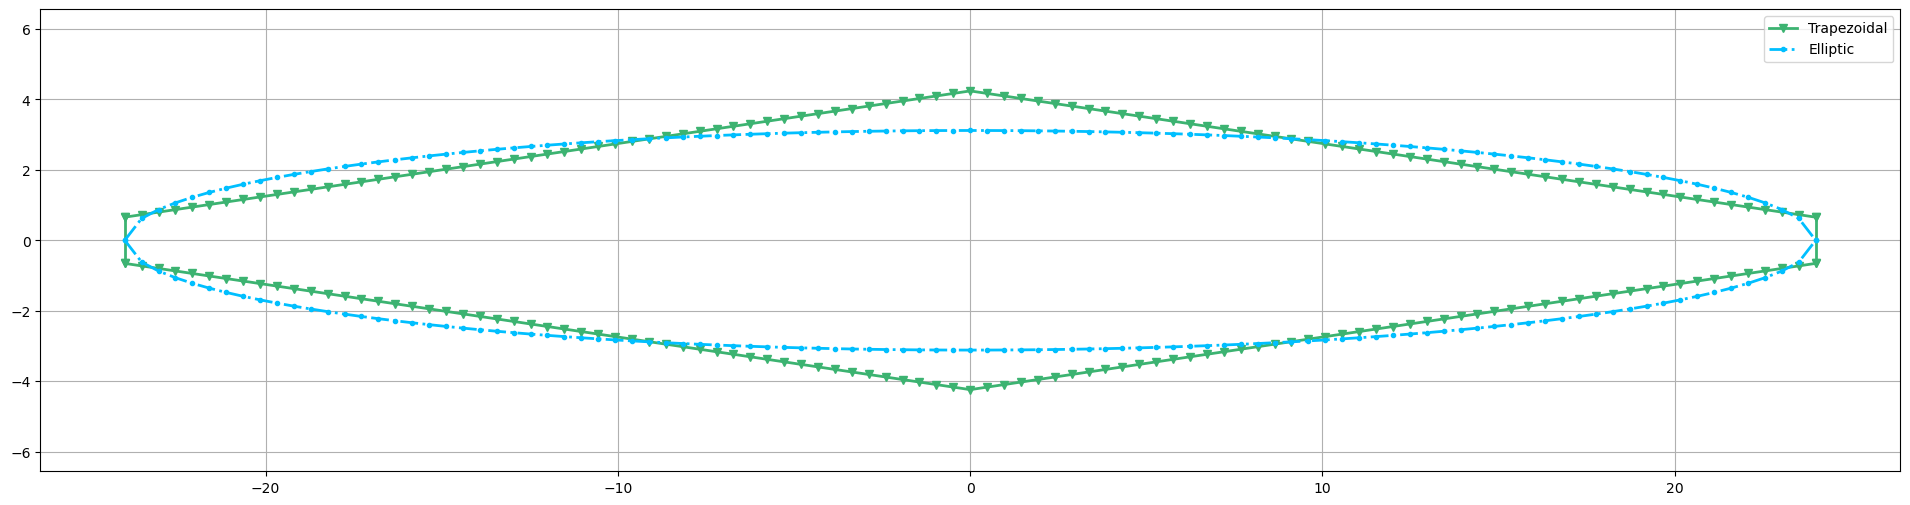

In [16]:
# Assigning values to variables
S = 235  # Wing Area in square feet
root = 8.48  # Root Chord Length in feet
b = 48  # Wing Span in feet
Vcruise = 350  # Cruise Speed in mph
h = 22000  # Geometric Cruise Altitude in feet
W = 9200  # Loaded Weight in lbs
μ = 3.25e-6  # Dynamic Viscosity (at h) in slugs/(ft * s)


def TrapezoidalWing(b, S, root):
    # b is the span of our wing
    # S is the area of our wing
    # root is the root chord length, we've been given these values in Project 6 and Project 7 Statement

    # First we need a variable for the span of our wing
    span = np.linspace(-b/2, b/2, 101)

    # Then we would like to calculate the chord length of our wing tip
    tip = (2 * S) / b - root

    m = ((root/2) - (tip/2))/ (b/2)
    x = (root/2) - abs(m*span)

    chord = 2 *  x

    # Plotting Functions:
    # Leading Edge
    plt.plot(span, chord/2, color = 'mediumseagreen', linewidth = 2, marker = 'v', label = 'Trapezoidal')

    # Trailing Edge
    plt.plot(span,-chord/2, color = 'mediumseagreen' , linewidth = 2, marker = 'v')

    # Left
    plt.plot([span[0] , span[0]] ,[-chord[0]/2, chord[0]/2], color = 'mediumseagreen' , linewidth = 2, marker = 'v')

    # Right
    plt.plot([span[-1] , span[-1]] ,[-chord[-1]/2, chord[-1]/2], color = 'mediumseagreen' , linewidth = 2, marker = 'v')

    
    return span, chord

def EllipticalWing(b, S):
    # b is the span of our wing
    # root is the root chord length, we've been given these values in Project 6 and Project 7 Statement
    croot = (4 * S) / (np.pi * b)

    # First we need a variable for the span of our wing
    span = np.linspace(-b/2, b/2, 101)

    # Then we need to calculate the chord of our wing
    chord = 2 *  (croot/2) * np.sqrt(1 - ((span)/(b/2))**2)

    # Plotting Functions
    plt.plot(span, chord/2, color = 'deepskyblue', linestyle = '-.', linewidth = 2, marker = '.', label = 'Elliptic')
    plt.plot(span, -chord/2, color = 'deepskyblue', linestyle = '-.', linewidth = 2, marker = '.')


    return span, chord

# Now, we just need to create a new figure and then run both functions. 

plt.figure(1, figsize = (24 ,6))
span, cT = TrapezoidalWing(b, S, root)
span, cE = EllipticalWing(b, S)
plt.legend(loc = 'best')
plt.grid(True)
plt.axis('equal')
plt.show()

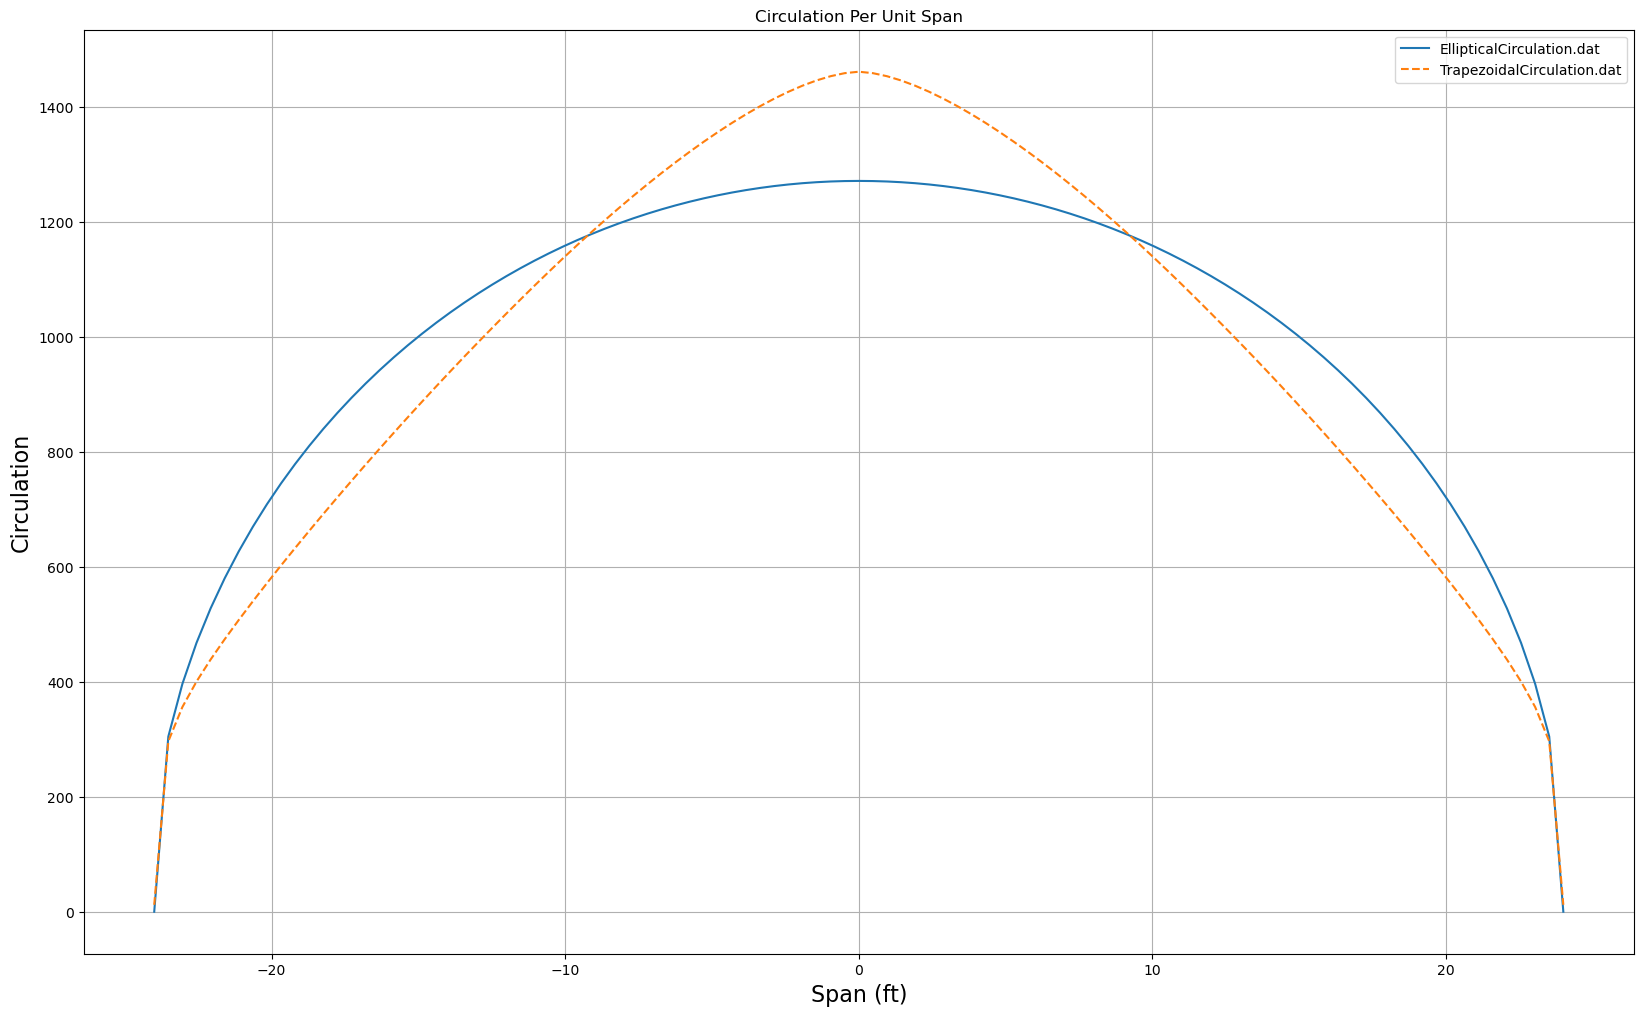

In [14]:
filenames = ['Data/circulation/EllipticalCirculation.dat', 'Data/circulation/TrapezoidalCirculation.dat']

plt.figure(figsize=(20, 12))
plt.grid(True)
plt.xlabel('Span (ft)', fontsize=16)
plt.ylabel('Circulation', fontsize=16)

# Define a list of line styles for each file
line_styles = ['-', '--']

for filename, line_style in zip(filenames, line_styles):
    # Load data from file
    data = np.loadtxt(filename, dtype=float, unpack=True, skiprows=1)
    span, circu = data[0], data[1]

    # Plot the data with the specified line style
    plt.plot(span, circu, label=filename.split('/')[-1], linestyle=line_style)

plt.title('Circulation Per Unit Span')
plt.legend()
plt.show()


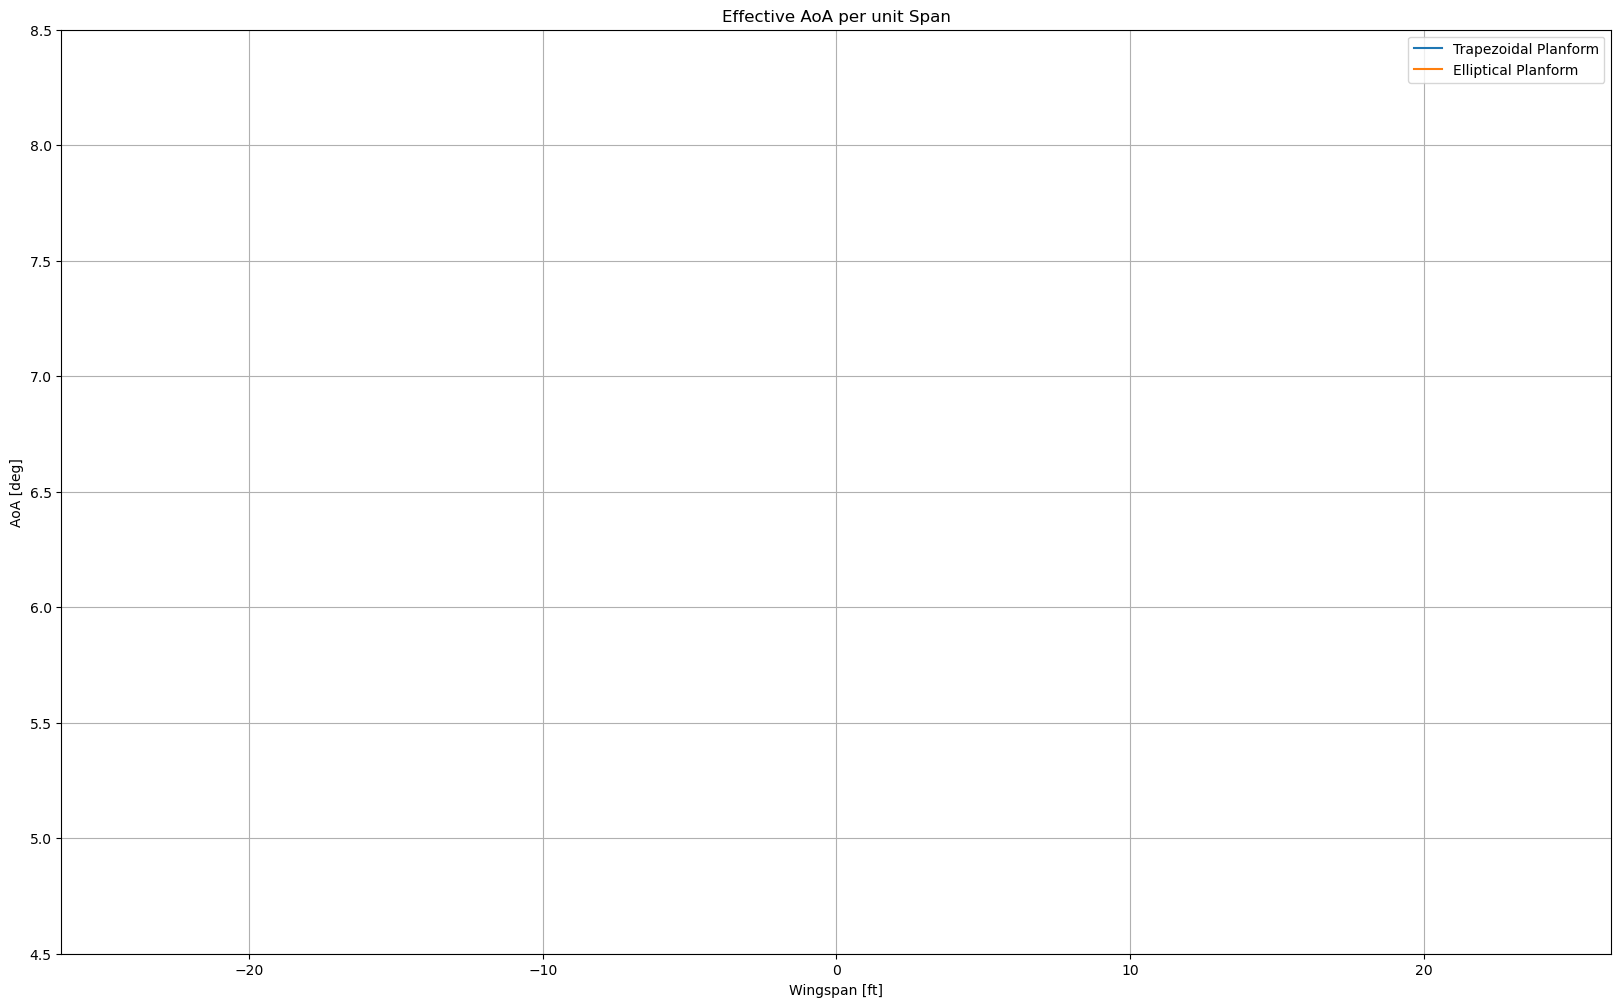

In [14]:
# Lets Start with Calculating Induced AoA
alpha = 20 * (np.pi/180)

# We need some variables to hold our induced alpha
ai_T = np.zeros(101)
ai_E = np.zeros(101)

# We'll eventually need the Velocity of our aircraft

Vinf_mph = 350 # mph

# We should convert this to ft/seconds
Vinf = Vinf_mph * 5280 / 3600

filename = 'Data/circulation/TrapezoidalCirculation.dat'
sT, gT = np.loadtxt(filename, skiprows=1, unpack=True)

filename = 'Data/circulation/EllipticalCirculation.dat'
sE, gE = np.loadtxt(filename, skiprows=1, unpack=True)

nT = len(gT)

dGammaT = np.zeros(nT)
dGammaE = np.zeros(nT)

# Here we need to calculate the derivative of circulation with respect to span.

for i in range(0, nT-1):
    dGammaT[i] = (gT[i+1] - gT[i])/(sT[i+1] - sT[i])
    dGammaE[i] = (gE[i+1] - gE[i])/(sE[i+1] - sE[i])

# Now we need to sum the circulation effects by spanwise location:
for i in range(0, nT):

    integT = np.zeros(nT)
    integE = np.zeros(nT)

    dy_T = sT[1] - sT[0]
    xi_T = sT + dy_T/2

    dy_E = sE[1] - sE[0]
    xi_E = sE + dy_E/2


    for j in range(0, 100):
        integT[j] = dGammaT[j] / (sT[i] - xi_T[j]) 
        integE[j] = dGammaE[j] / (sE[i] - xi_E[j])
    
    J_T = np.trapz(integT[:-1], xi_T[:-1])
    J_E = np.trapz(integE[:-1], xi_E[:-1])


    # Now that we have calculated J, we can calculate our induced angle of attack 

    ai_T[i] = (1/(4*np.pi*Vinf) * J_T) 
    ai_E[i] = (1/(4*np.pi*Vinf) * J_E) 

ai_T[0] = 2*ai_T[1] - ai_T[2]
ai_T[-1] = 2*ai_T[-2] - ai_T[-3]

ai_E[0] = 2*ai_E[1] - ai_E[2]
ai_E[-1] = 2*ai_E[-2] - ai_E[-3]

plt.figure(figsize = (20,12))
plt.title('Effective AoA per unit Span')
# Input the plotting functions for your effective angle of attack for both planforms
plt.plot(sT, ai_T, label='Trapezoidal Planform')
plt.plot(sE, ai_E, label='Elliptical Planform')
plt.xlabel('Wingspan [ft]')
plt.ylabel('AoA [deg]')
plt.ylim([4.5 , 8.5])
plt.legend()
plt.grid(True)
plt.show()

# Probelem 3 

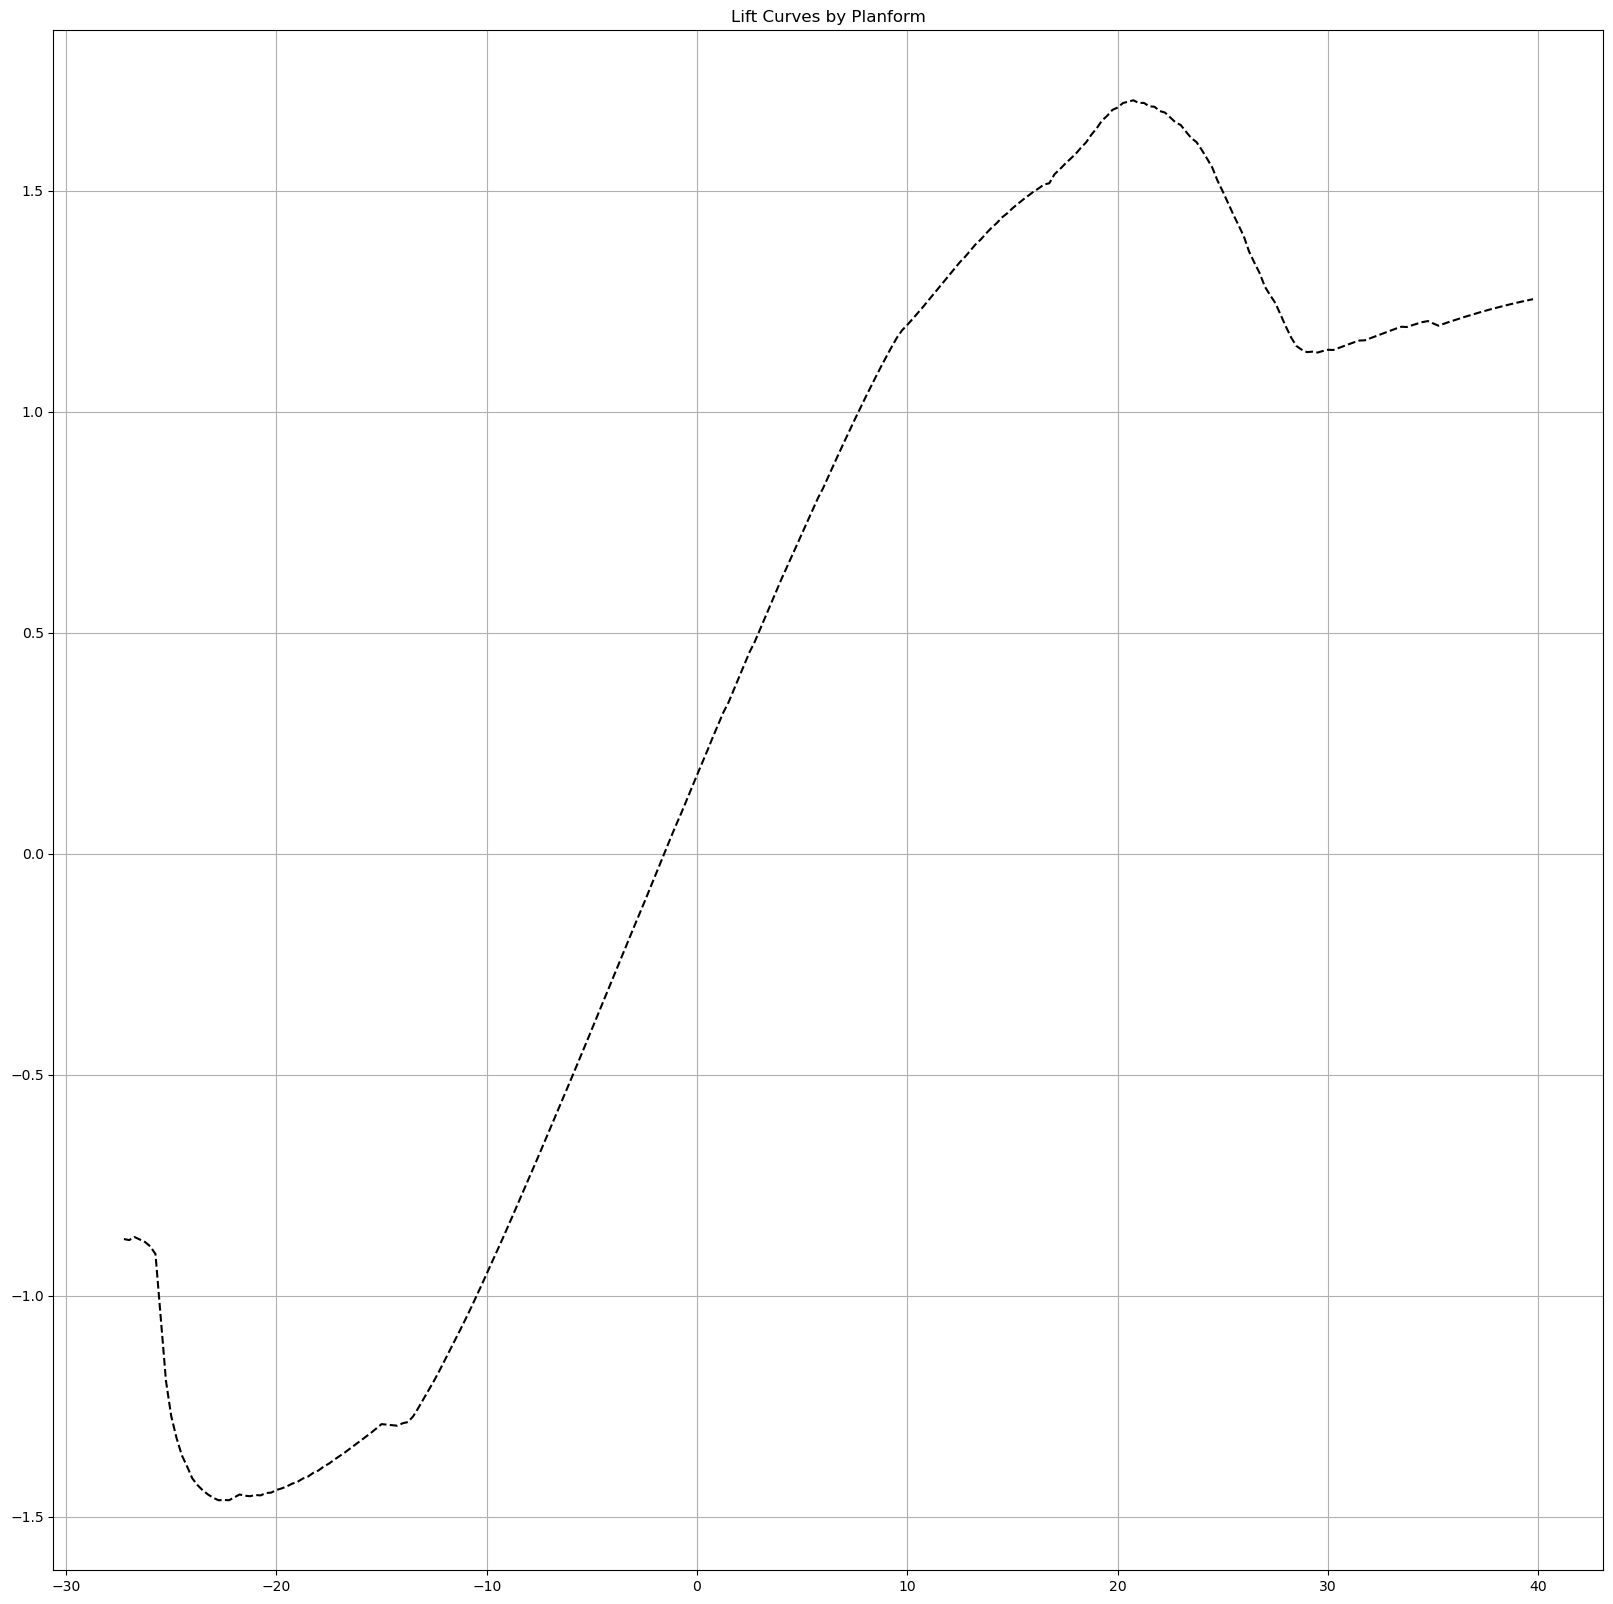

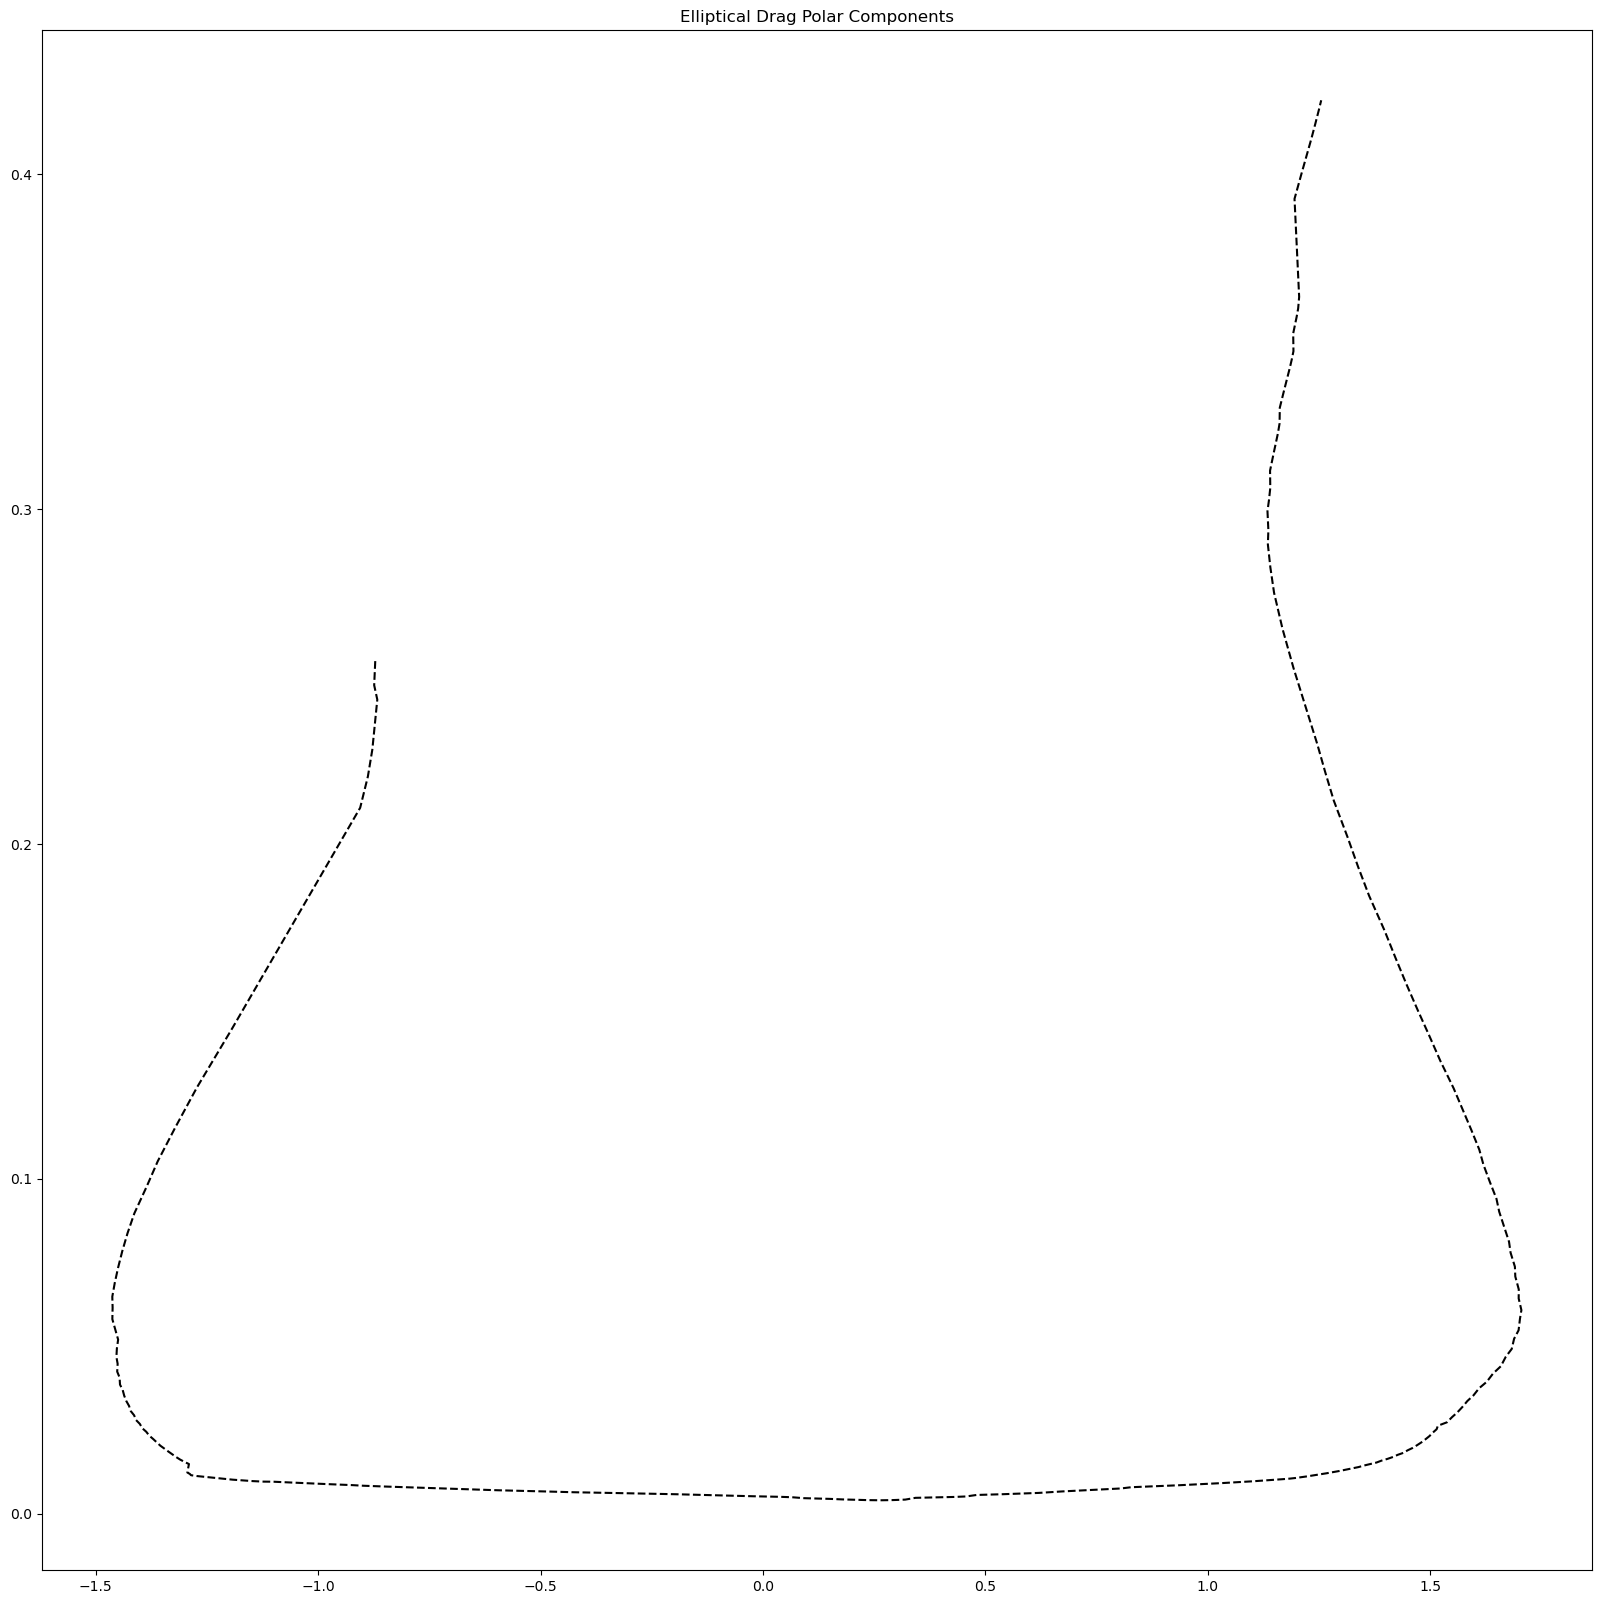

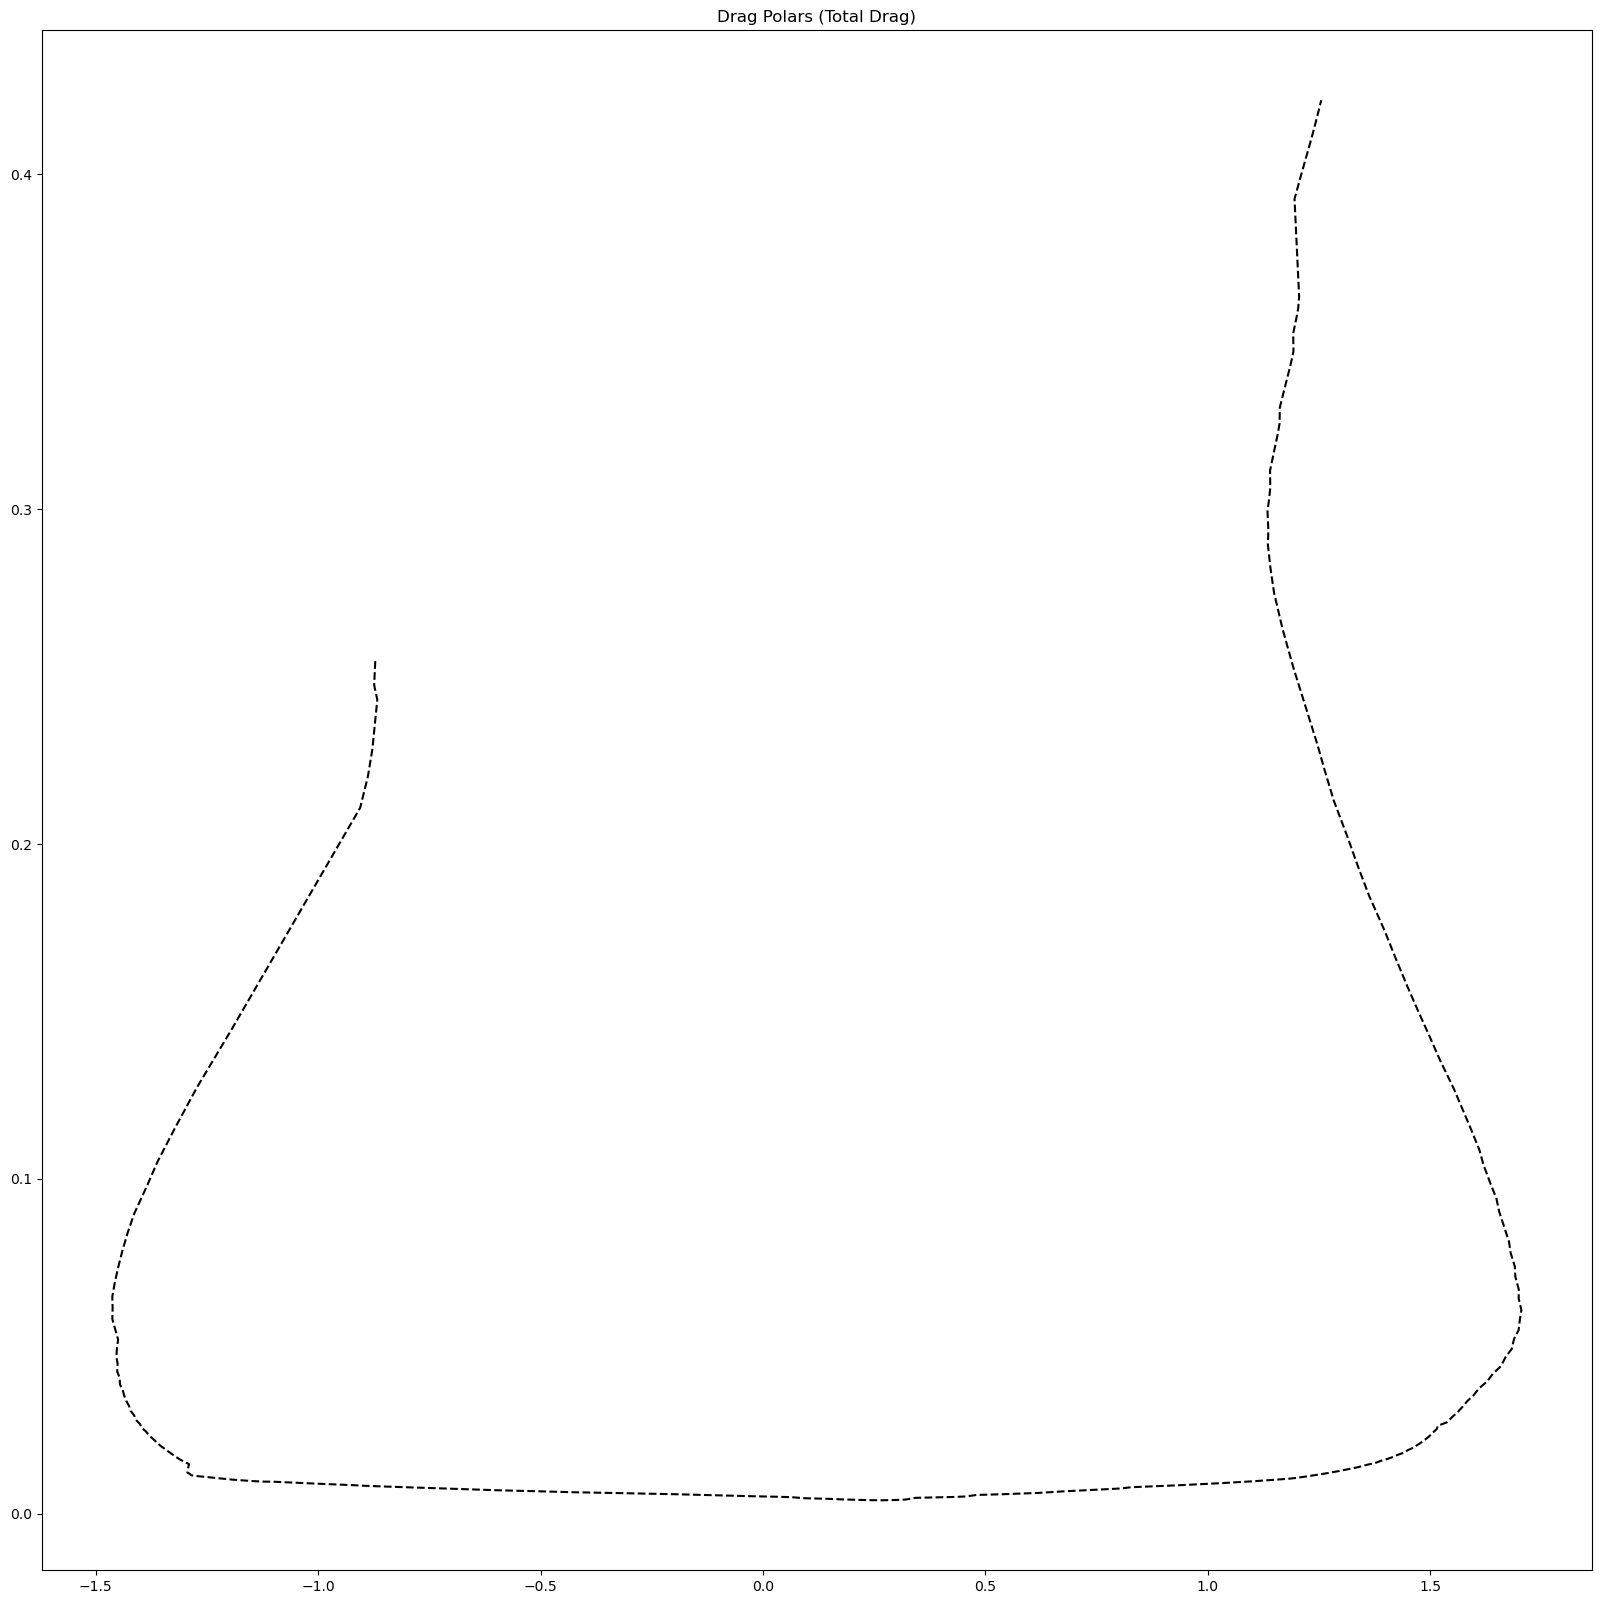

In [6]:
def AoA_Calculation(gamma, span, alpha):
    # First, we'll need a variable for integration later/
    
    #
    nT = len(gT)
    

    dGamma = np.zeros(nT)
    ai_new = np.zeros(nT)
    ae_new = np.zeros(nT)
    # Here we need to calculate the derivative of circulation with respect to span.
    gamma[0], gamma[-1] = 0, 0

    for i in range(0, nT-1):
        dGamma[i] = (gamma[i+1] - gamma[i])/(span[i+1] - span[i])

    # Now we need to sum the circulation effects by spanwise location:
    for i in range(0, nT):

        integ = np.zeros(nT)

        dy = span[1] - span[0]
        xi = span + dy/2


        for j in range(0, 100):
            integ[j] = dGamma[j] / (span[i] - xi[j]) 

    
        J = np.trapz(integ[:-1], xi[:-1])

        # Now that we have calculated J, we can calculate our induced angle of attack 
        ai_new[i] = 1/(4*np.pi*Vinf) * J

    ai_new[0] = 2*ai_new[1] - ai_new[2]
    ai_new[-1] = 2*ai_new[-2] - ai_new[-3]


    for i in range(0, 101):
        ae_new[i] = alpha - (ai_new[i] * (180/np.pi))

    return ae_new, ai_new


def CircIteration(Gam, span, chord, alpha):
    R = 0
    Vinf = 513.33333
    S = 235 
    
    damping=0.15
    max_iter = 800
    max_res = 1e-4

    new_Gamma = np.zeros(len(Gam))
    Cl_holder= np.zeros(len(Gam))
    dv = np.zeros(len(Gam))

    filename = 'Data/p51d/p51d.polar.dat'
    a, Cl_iter, Cd_iter, A, B, C, D = np.loadtxt(filename, skiprows = 12, unpack = True)

    root = round(len(chord)/2)
    # We always need to start with an initial circulation calculation or guess:
    # We start by assuming that our circulation for the wing is an elliptic distribution, based on the chord

    #Initial root circulation guess (elliptic)
    Gam0 = np.pi * chord[root]  / (1 + np.pi * chord[root]/2)


    b = max(span) - min(span)

    #Initial circulation distribution (elliptic)
    new_Gamma = Gam0 * np.sqrt(1 - (2* span / b)**2)
    #new_Gamma[0], new_Gamma[-1] = 0, 0 
    #new_Gamma = Gam

    iter = 1
    res = max_res+1
    j  = 0
    while iter < max_iter and j < 3:
        #CALC NEW CIRCULATION DITRIBUTION
        
        ae, ai = AoA_Calculation(new_Gamma, span, alpha)

        old_Gamma = new_Gamma
        n = len(ae)

        for i in range(0,n):
            Cl_holder[i] = np.interp(ae[i], a, Cl_iter)
            new_Gamma[i] = 0.5 * Vinf * chord[i] * Cl_holder[i]

        #CALC RESIDUAL (difference between current and prev solution)
        R = new_Gamma - old_Gamma
        R = R[5:-5] / old_Gamma[5:-5]

        res = max(abs(R)) #check convergence along entire wing
        # res = abs(R[self.iroot]) #only check root circulation convergence

        #stop iteration when residual has been less than maxres for 5 iters
        if res < max_res:
            j += 1
            # j = 5 #skip the 5 steps after residual

        #SAVE NEW CIRCULATION DISTRIBUTION (use SUR)
        new_Gamma = old_Gamma + damping * (new_Gamma - old_Gamma)


        #increment iteration count
        iter += 1

    fin_iter = iter - 1 #save final iteration count

    # Calculating Lift and Drag
    indices = [int(x) for x in np.linspace(1, 100, 101)]

    # integration function
    f = new_Gamma[indices]

    # integration variable
    dx = span[indices]
    
    coeff_L = np.trapz(f * dx, dx) / (qinf * S)

    f = new_Gamma[indices]

    coeff_Di = np.trapz(f * dx, dx) / (qinf * S)

    qinf = 0.5*rho* (Vinf**2)

    for i in range(0, n):
        CDv = np.interp(ae[i], a, Cd_iter)
        dv[i] = CDv * qinf * chord[i]
    
    D = np.trapz(dv, x = span)
    coeff_Dv = D / (qinf * S)


    return coeff_L, coeff_Di, coeff_Dv


plt.figure(figsize = (20,20))
plt.grid(True)

alpha_sweep = np.linspace(0, 30, 25)
n = len(alpha_sweep)


filename = 'Data/p51d/p51d.polar.dat'
alpha, Cl, Cd, A, B, C, D = np.loadtxt(filename, skiprows = 12, unpack = True)
plt.title('Lift Curves by Planform')
plt.plot(alpha, Cl, color = 'k', linestyle = '--', label ='2D')

plt.show()

plt.figure(figsize = (20,20))
plt.title('Elliptical Drag Polar Components')
plt.plot(Cl, Cd, color = 'k', linestyle = '--', label ='2D')

plt.show()


plt.figure(figsize = (20,20))
plt.title('Drag Polars (Total Drag)')
plt.plot(Cl, Cd, color = 'k', linestyle = '--', label ='2D')

plt.show()

# Problem 4.) Washout and Stall Analysis


## Appraoch

## Equations

## Code

(array([187], dtype=int64),)
20.75


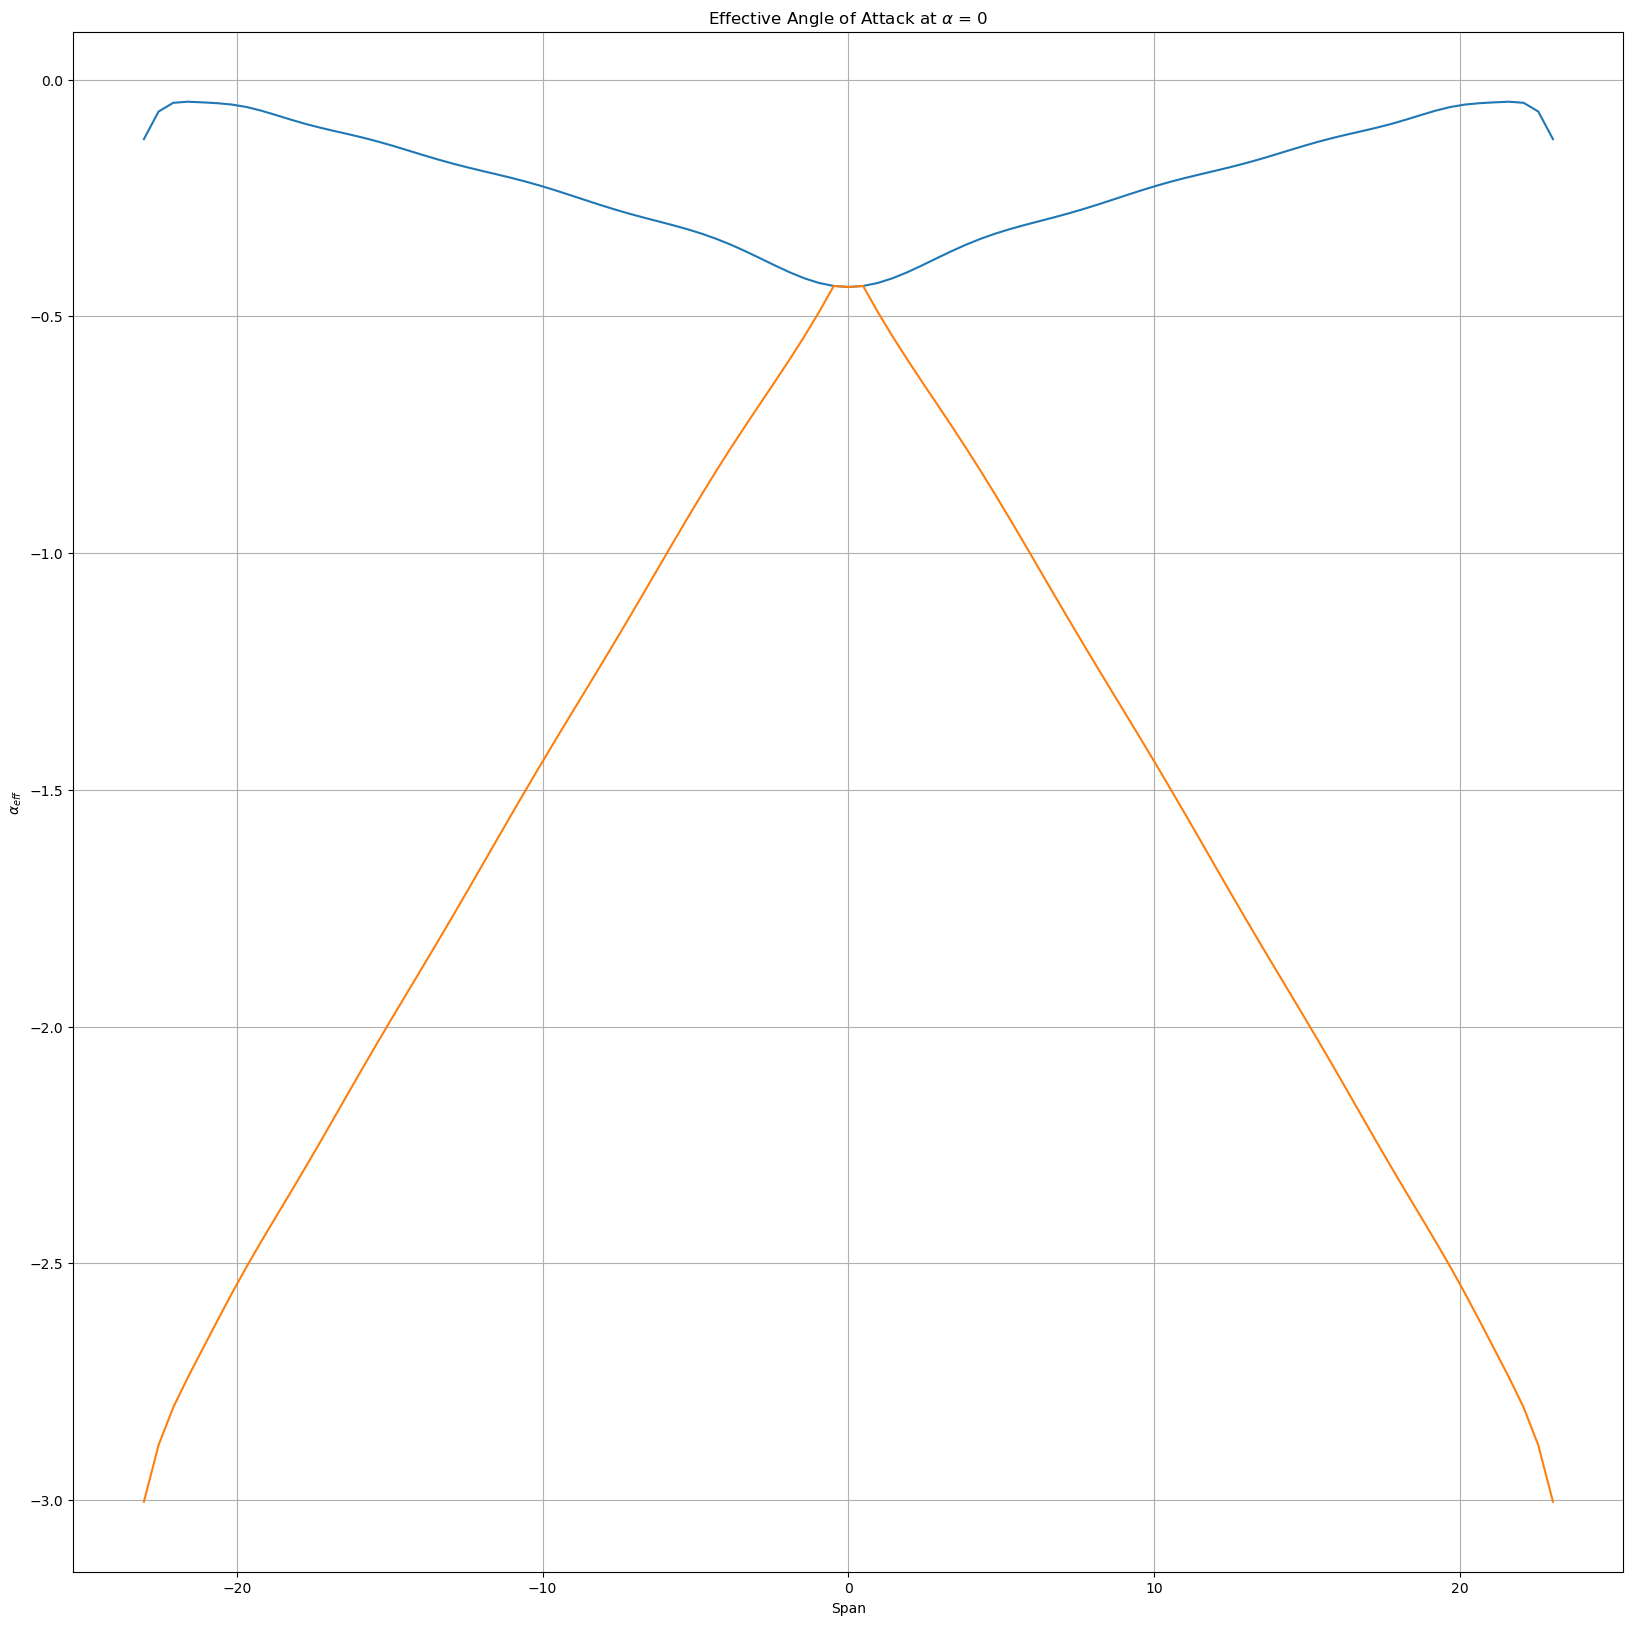

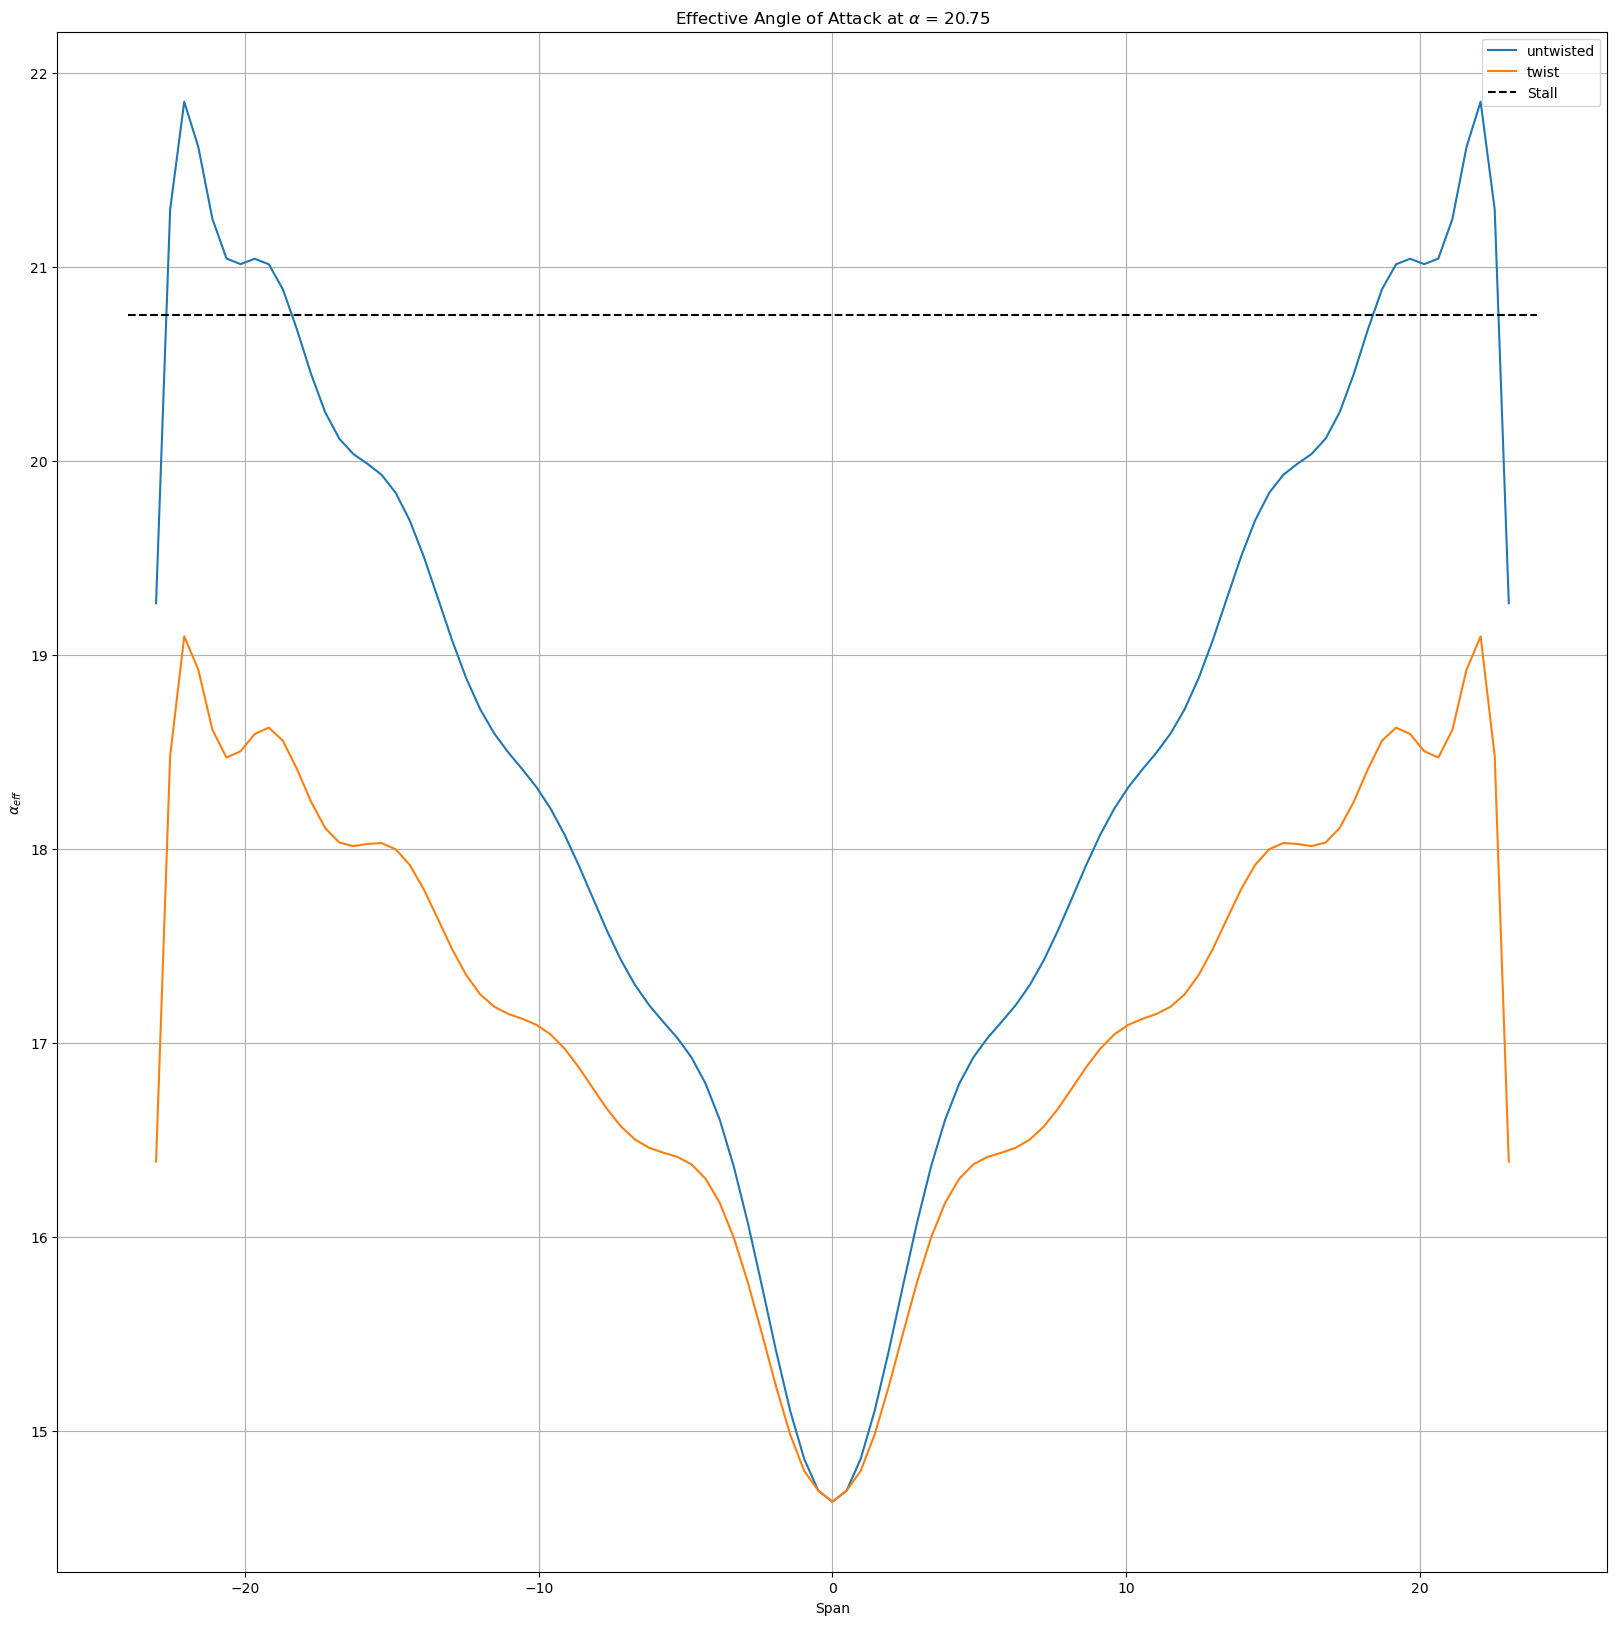

In [17]:
def AoA_Calculation(gamma, span, alpha):
    # First, we'll need a variable for integration later/
    
    #
    nT = len(gT)
    Vinf = 513.333333

    dGamma = np.zeros(nT)
    ai_new = np.zeros(nT)
    ae_new = np.zeros(nT)
    # Here we need to calculate the derivative of circulation with respect to span.
    gamma[0], gamma[-1] = 0, 0

    for i in range(0, nT-1):
        dGamma[i] = (gamma[i+1] - gamma[i])/(span[i+1] - span[i])

    # Now we need to sum the circulation effects by spanwise location:
    for i in range(0, nT):

        integ = np.zeros(nT)

        dy = span[1] - span[0]
        xi = span + dy/2

        for j in range(0, 100):
            integ[j] = dGamma[j] / (span[i] - xi[j]) 

    
        J = np.trapz(integ[:-1], xi[:-1])

        # Now that we have calculated J, we can calculate our induced angle of attack 
        ai_new[i] = 1/(4*np.pi*Vinf) * J

    ai_new[0] = 2*ai_new[1] - ai_new[2]
    ai_new[-1] = 2*ai_new[-2] - ai_new[-3]


    for i in range(0, 101):
        ae_new[i] = alpha - (ai_new[i] * (180/np.pi))

    coeff = np.polyfit(span, ae_new, 25)
    p = np.poly1d(coeff)
    ae_fin = p(span)

    return ae_fin, ai_new
filename = 'Data/p51d/p51d.polar.dat'
alpha, Cl, Cd, A, B, C, D = np.loadtxt(filename, skiprows = 12, unpack = True)

# Here, we grab our values from the p51 polar.
# Next, we find the point of stall where Cl is a maximum

a = np.where(Cl == max(Cl))
print(a)
print(alpha[187])

# So here we have the angle of attack of 20.75 where our stall occurs. Now that we know when stall occurs, we should determine the effective angle of attack for our wing.
# We need to set up our wing. Let's determine how our untwisted wing performs at an angle of attack of 0.
# We'll need to run our adjusted equations from above.
# Our goal is to first figure out the effective angle of attack and the induced angle of attack. We're running this at 0 angle of attack and for our trapezoidal wing

filename = 'Data/circulation/TrapezoidalCirculation_a0.dat'
span0, gamma0 = np.loadtxt(filename, skiprows = 1, unpack = True)

# Need to calculate the effective angle of attack at 0
alpha_eff0, alpha_ind0 = AoA_Calculation(gamma0, span, 0)

# Now we have our untwisted wing solved at an angle of attack of 0
# Our next step is to apply 3 degrees of twist to the wing.

alpha_untwist = alpha_eff0

twist_array = np.linspace(0, 3, 50)
twist_array2 = np.linspace(3, 0, 50)
zzero = np.array([0])
twist = np.concatenate((twist_array2, zzero, twist_array), axis = 0)

alpha_twist = alpha_eff0 - twist

plt.figure(figsize = (20,20))
plt.title(r'Effective Angle of Attack at $\alpha$ = 0')
plt.plot(sT[2:-2], alpha_untwist[2:-2], label = 'untwisted')
plt.plot(sT[2:-2], alpha_twist[2:-2], label = 'twist')
plt.xlabel('Span')
plt.ylabel(r'$\alpha_{eff}$')
plt.grid(True)
plt.show()

# Here we can see how our wing is slightly twisted down at the wing tips. Neither of these comes close to our stall at alpha = 2-.75
#alpha_eff20, alpha_ind20 = AoA_Calculation(gamma, span, 20.75)

filename = 'Data/circulation/TrapezoidalCirculation_a20.dat'
span20, gamma20 = np.loadtxt(filename, skiprows = 1, unpack = True)

# Need to calculate the effective angle of attack at 0
alpha_eff20 , alpha_ind20 = AoA_Calculation(gamma20, span20, 20.75)


wing_twist = alpha_eff20 - twist


plt.figure(figsize = (20,20))
plt.title(r'Effective Angle of Attack at $\alpha$ = 20.75')
plt.plot(sT[2:-2], alpha_eff20[2:-2], label = 'untwisted')
plt.plot(sT[2:-2], wing_twist[2:-2], label = 'twist')
plt.plot(sT, 20.75*np.ones(101), color = 'k', linestyle = '--', label = 'Stall')
plt.xlabel('Span')
plt.ylabel(r'$\alpha_{eff}$')
plt.legend(loc = 'best')
plt.grid(True)
plt.show()